## Aligning PPG To ECG

Here we refer to the time window as the frame. Each frame is 0.033 sec front and back (so 0.67 total)

In [1]:
import numpy
import matplotlib.pyplot as plt
import os
fps = 30.323427803

In [2]:
def convertStrLToIntL(array):
    for i in range(len(array)):
        array[i] = int(array[i])
    return array
f = open('/home/mong/Desktop/map/map/videos/15012301_GIO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-1]
rrData = rrSection.split('\n')
#get rid of header
ecg1 = rrData[1:-1]
ecg1 = convertStrLToIntL (ecg1)

#second hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GLO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-2]
rrData = rrSection.split('\n')
#get rid of header
ecg2 = rrData[1:]
ecg2 = convertStrLToIntL (ecg2)

In [3]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [4]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [5]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

In [6]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.0:
        return True
    else:
        return False

In [7]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if (not isTrueRRInterval(rrInterval)):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0


In [8]:
def analyzeVideoAndObtainBestRedRRInterval(fileName):
    rErrorL = []
    rL, gL, bL = readFromFile(fileName)
    bestRRL = None
    bestPercentErrorSoFar = 101
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        if getPercentError(rRRL) < bestPercentErrorSoFar:
            bestPercentErrorSoFar = getPercentError(rRRL)
            bestRRL = rRRL
    return bestRRL

In [9]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173427_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_172857_Q.mp4.txt"]

In [10]:
def convertSecToMS(array):
    for i in range(len(array)):
        array[i] = round(array[i]*1000)
    return array

In [11]:
vidPPGL = {}
for video in videoList:
    vidPPGL[os.path.basename(video)] = convertSecToMS(analyzeVideoAndObtainBestRedRRInterval(video))
    

In [12]:
def constructTimeListFromRRInterval(rrList):
    #construct time array from the rr intervals
    tList = []
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[-1] + float(rrList[i]))
    return tList

In [13]:
mong =0
def getInsertionIndex(array, v):
    #v is not in range of array
    if v < array[0] or array[-1] < v:
        return -1
    for i in range(len(array)):
        if v < array[i]:
            return i-1
l = [833.0, 1686.0, 2553.0, 3369.0, 4141.0, 4918.0, 5720.0]
getInsertionIndex(l, 5000) 

5

In [17]:
mong = 0
def align(ecg, ppg):
    ecgTimeL = constructTimeListFromRRInterval(ecg)
    ppgTimeL = constructTimeListFromRRInterval(ppg)
    def getAlignmentDistanceForOneRR(timeOffset, rrIndex):
        #calculate projected distance from ppg to ecg
        ppgTimeProjectedOntoEcg = ppgTimeL[rrIndex] + timeOffset
        ecgProjectedIndexLeft = getInsertionIndex(ecgTimeL, ppgTimeProjectedOntoEcg)
        #if out of bound
        if ecgProjectedIndexLeft == -1:
            return -1
        ecgProjectedIndexRight = ecgProjectedIndexLeft+1
        slope = (ecg[ecgProjectedIndexRight]-ecg[ecgProjectedIndexLeft])/(ecgTimeL[ecgProjectedIndexRight]-ecgTimeL[ecgProjectedIndexLeft])
        deltaT = ppgTimeProjectedOntoEcg - ecgTimeL[ecgProjectedIndexLeft]
        deltaRR = slope * deltaT
        projectedRR = ecg[ecgProjectedIndexLeft] + deltaRR
        
                           
        return abs(projectedRR - ppg[rrIndex])
#     distanceForCurrentRR = getAlignmentDistanceForOneRR(ecgTimeL[1], 1)
    #begin alignment
    alignmentT = None
    minDistance = 100000
    #align according to the first rr of ppg
    for timeOffset in ecgTimeL:
        breakOuter = False
        totalDistance = 0
        for rrIndex in range(len(ppg)):
            distanceForCurrentRR = getAlignmentDistanceForOneRR(timeOffset, rrIndex)
            if distanceForCurrentRR == -1:
                return alignmentT, minDistance
            totalDistance += distanceForCurrentRR
        if totalDistance < minDistance:
            minDistance = totalDistance
            alignmentT = timeOffset
#     #in case the first rr from ppg is a false rr
#     for timeOffset in ecgTimeL:
#         totalDistance = 0
#         for rrIndex in range(len(ppg)):
#             distanceForCurrentRR = getAlignmentDistanceForOneRR(timeOffset - ppgTimeL[0], rrIndex)
#             if distanceForCurrentRR == -1:
#                 continue
#             totalDistance += distanceForCurrentRR
#         if totalDistance < minDistance:
#             minDistance = totalDistance
#             alignmentT = timeOffset
    return alignmentT, minDistance
print('aligning video to first ecg signals')
for vid in vidPPGL:
    alignmentT, minDistance = align(ecg1, vidPPGL[vid])
    alignmentT = alignmentT/60/1000
    print(vid, alignmentT, 'min')
print('aligning video to second ecg signals')
for vid in vidPPGL:
    alignmentT, minDistance = align(ecg2, vidPPGL[vid])
    alignmentT = alignmentT/60/1000
    print(vid, alignmentT, 'min')

aligning video to first ecg signals
VID_20150123_173629_F.mp4.txt 0.013883333333333333 min
VID_20150123_173427_F.mp4.txt 0.44708333333333333 min
VID_20150123_173757_Q.mp4.txt 9.419216666666667 min
VID_20150123_172926_F.mp4.txt 0.013883333333333333 min
VID_20150123_173700_Q.mp4.txt 8.460049999999999 min
VID_20150123_173259_Q.mp4.txt 4.455616666666667 min
VID_20150123_173358_Q.mp4.txt 5.437783333333334 min
VID_20150123_173329_F.mp4.txt 0.0281 min
VID_20150123_173028_F.mp4.txt 0.013883333333333333 min
VID_20150123_173457_Q.mp4.txt 6.4153 min
VID_20150123_172857_Q.mp4.txt 0.44708333333333333 min
VID_20150123_173556_Q.mp4.txt 7.4055333333333335 min
aligning video to second ecg signals
VID_20150123_173629_F.mp4.txt 8.502066666666668 min
VID_20150123_173427_F.mp4.txt 8.5252 min
VID_20150123_173757_Q.mp4.txt 8.558833333333334 min
VID_20150123_172926_F.mp4.txt 1.6038166666666667 min
VID_20150123_173700_Q.mp4.txt 8.571316666666668 min
VID_20150123_173259_Q.mp4.txt 8.583133333333333 min
VID_20150

[ \sum_{i=1}^{30} \abs( x(i)-y(i) ) ] / [ \sum_{i=1}^{30} \abs( x(i) 

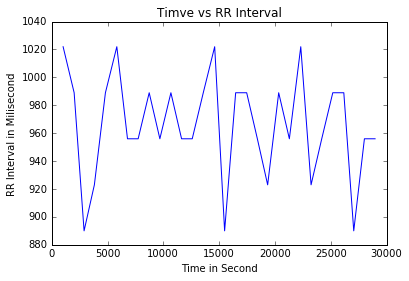

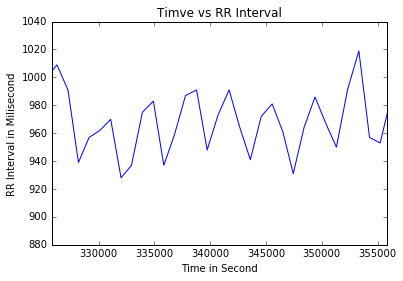

In [15]:
def plot(tList, rrList):
    #plotting the graph
    plt.plot(tList, rrList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.show()
# alignmentT, minDistance = align(ecg1, vidPPGL['VID_20150123_173457_Q.mp4.txt'])
%matplotlib inline
plt.plot(constructTimeListFromRRInterval(vidPPGL['VID_20150123_173457_Q.mp4.txt']), vidPPGL['VID_20150123_173457_Q.mp4.txt'])
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.show()




plt.plot(constructTimeListFromRRInterval(ecg1), ecg1)
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.xlim(5.43*60*1000, 5.43*60*1000+30000)
plt.ylim(880,1040)
plt.show()
